In [92]:
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tensor
spikes_tensor = torch.load("tensors/spike_data_tensor.pt" ,map_location=device)
labels_tensor = torch.load("tensors/labels_tensor.pt", map_location=device)

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

spikes_tensor = spikes_tensor.to(device)
labels_tensor = labels_tensor.to(device)

Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


In [93]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        # Random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Move tensors to the specified device
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

### Dataset and DataLoader Configuration

In [95]:
dataset = CCMKDataset(spikes_tensor, labels_tensor, nchannels=list(range(16)), seed=42)

# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

batch_size = 32
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Filtered Labels distribution after processing: tensor([1046, 1046])


In [96]:
import os
os.makedirs('saved_loaders_bs32', exist_ok=True)

torch.save(train_loader, 'saved_loaders_bs32/train_loader.pth')
torch.save(val_loader, 'saved_loaders_bs32/val_loader.pth')
torch.save(test_loader, 'saved_loaders_bs32/test_loader.pth')

In [57]:
# Adapted from Esther's snn.ipynb notebook

# Check the length of the dataset
print(f"Dataset length: {len(dataset)}")

# Get and print the shape of the first sample in the dataset
first_spikes, first_label = dataset[0]
print(f"Shape of the first spikes tensor: {first_spikes.shape}")
print(f"Label of the first sample: {first_label}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Get the distribution of labels
labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Dataset length: 2092
Shape of the first spikes tensor: torch.Size([16, 101])
Label of the first sample: 0
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([836, 836])


In [58]:
# Check the shape of tensors in a DataLoader
def check_dataloader_shapes(dataloader, loader_name=""):
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Loader: {loader_name}, Batch {batch_idx + 1}:")
        print(f" - Inputs shape: {inputs.shape}")  
        print(f" - Labels shape: {labels.shape}")  
        break 

check_dataloader_shapes(train_loader, "Train Loader")
check_dataloader_shapes(val_loader, "Validation Loader")
check_dataloader_shapes(test_loader, "Test Loader")


Loader: Train Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Validation Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Test Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])


### Network Initialization

In [59]:
import torch
import numpy as np
import random

# Reproducibility
seed = 42  

# Set seed for Python's built-in random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [91]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  # Number of input channels
n_classes = 1    # Number of output classes
n_time = 101     # Number of time steps
dt = 10e-3       # Time step duration (Should be equal to raster_period in audio processing)

model1 = SynNet(
    n_channels=n_channels,                        
    n_classes=n_classes,
    dt=dt,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[4, 8, 10], 
    tau_syn_base=0.02,  # must be larger than dt
    tau_mem=0.02,
    tau_syn_out=0.02
)

print(model1)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


### Train & Validation

### Model 1 - Spike output

In [61]:
os.environ["WANDB_NOTEBOOK_NAME"] = "data_loader_to_model_training.ipynb"

  1%|          | 1/100 [00:30<50:57, 30.88s/it]

Epoch 1/100, Training Loss: 445.8266509433962, Validation Loss: 53.57142857142857


  2%|▏         | 2/100 [00:52<41:35, 25.46s/it]

Epoch 2/100, Training Loss: 63.727004716981135, Validation Loss: 53.57142857142857


  3%|▎         | 3/100 [01:13<37:30, 23.20s/it]

Epoch 3/100, Training Loss: 403.5518867924528, Validation Loss: 53.57142857142857


  4%|▍         | 4/100 [01:33<35:26, 22.15s/it]

Epoch 4/100, Training Loss: 49.823113207547166, Validation Loss: 53.57142857142857


  5%|▌         | 5/100 [01:54<34:13, 21.61s/it]

Epoch 5/100, Training Loss: 50.0, Validation Loss: 53.57142857142857


  6%|▌         | 6/100 [02:15<33:45, 21.55s/it]

Epoch 6/100, Training Loss: 50.530660377358494, Validation Loss: 53.57142857142857


  7%|▋         | 7/100 [02:35<32:38, 21.06s/it]

Epoch 7/100, Training Loss: 49.649174528301884, Validation Loss: 214.66071428571428


  8%|▊         | 8/100 [03:00<34:09, 22.28s/it]

Epoch 8/100, Training Loss: 70.24174528301887, Validation Loss: 53.57142857142857


  9%|▉         | 9/100 [03:20<32:45, 21.60s/it]

Epoch 9/100, Training Loss: 50.0, Validation Loss: 53.57142857142857


 10%|█         | 10/100 [03:40<31:33, 21.04s/it]

Epoch 10/100, Training Loss: 90.05306603773585, Validation Loss: 42.59375


 11%|█         | 11/100 [04:03<31:55, 21.53s/it]

Epoch 11/100, Training Loss: 52.62146226415094, Validation Loss: 45.651785714285715


 12%|█▏        | 12/100 [04:23<31:14, 21.30s/it]

Epoch 12/100, Training Loss: 76.09021226415095, Validation Loss: 50.285714285714285


 13%|█▎        | 13/100 [04:45<31:00, 21.38s/it]

Epoch 13/100, Training Loss: 43.760613207547166, Validation Loss: 39.40625


 14%|█▍        | 14/100 [05:05<30:14, 21.10s/it]

Epoch 14/100, Training Loss: 47.61143867924528, Validation Loss: 37.5


 15%|█▌        | 15/100 [05:27<29:57, 21.15s/it]

Epoch 15/100, Training Loss: 47.28596698113208, Validation Loss: 41.74107142857143


 16%|█▌        | 16/100 [05:47<29:04, 20.77s/it]

Epoch 16/100, Training Loss: 39.185731132075475, Validation Loss: 34.95982142857143


 17%|█▋        | 17/100 [06:08<28:53, 20.89s/it]

Epoch 17/100, Training Loss: 46.755896226415096, Validation Loss: 34.82142857142857


 18%|█▊        | 18/100 [06:29<28:47, 21.07s/it]

Epoch 18/100, Training Loss: 41.31367924528302, Validation Loss: 39.674107142857146


 19%|█▉        | 19/100 [06:51<28:47, 21.33s/it]

Epoch 19/100, Training Loss: 42.19516509433962, Validation Loss: 33.41517857142857


 20%|██        | 20/100 [07:12<28:18, 21.23s/it]

Epoch 20/100, Training Loss: 36.875, Validation Loss: 33.40625


 21%|██        | 21/100 [07:34<28:01, 21.28s/it]

Epoch 21/100, Training Loss: 78.81308962264151, Validation Loss: 35.098214285714285


 22%|██▏       | 22/100 [07:55<27:35, 21.22s/it]

Epoch 22/100, Training Loss: 36.935731132075475, Validation Loss: 34.07142857142857


 23%|██▎       | 23/100 [08:15<27:02, 21.07s/it]

Epoch 23/100, Training Loss: 36.5436320754717, Validation Loss: 28.651785714285715


 24%|██▍       | 24/100 [08:35<26:03, 20.58s/it]

Epoch 24/100, Training Loss: 30.225825471698112, Validation Loss: 22.084821428571427


 25%|██▌       | 25/100 [08:55<25:32, 20.44s/it]

Epoch 25/100, Training Loss: 33.675707547169814, Validation Loss: 26.022321428571427


 26%|██▌       | 26/100 [09:14<24:32, 19.90s/it]

Epoch 26/100, Training Loss: 26.472877358490567, Validation Loss: 28.647321428571427


 27%|██▋       | 27/100 [09:32<23:50, 19.60s/it]

Epoch 27/100, Training Loss: 27.0625, Validation Loss: 24.276785714285715


 28%|██▊       | 28/100 [09:51<23:15, 19.38s/it]

Epoch 28/100, Training Loss: 25.829009433962263, Validation Loss: 23.008928571428573


 29%|██▉       | 29/100 [10:11<22:54, 19.35s/it]

Epoch 29/100, Training Loss: 25.767688679245282, Validation Loss: 22.1875


 30%|███       | 30/100 [10:31<22:56, 19.66s/it]

Epoch 30/100, Training Loss: 26.47110849056604, Validation Loss: 23.035714285714285


 31%|███       | 31/100 [10:50<22:12, 19.31s/it]

Epoch 31/100, Training Loss: 24.982311320754718, Validation Loss: 21.25


 32%|███▏      | 32/100 [11:09<21:49, 19.26s/it]

Epoch 32/100, Training Loss: 25.13443396226415, Validation Loss: 22.607142857142858


 33%|███▎      | 33/100 [11:28<21:27, 19.22s/it]

Epoch 33/100, Training Loss: 23.57134433962264, Validation Loss: 20.772321428571427


 34%|███▍      | 34/100 [11:46<20:50, 18.95s/it]

Epoch 34/100, Training Loss: 23.40801886792453, Validation Loss: 21.625


 35%|███▌      | 35/100 [12:05<20:24, 18.84s/it]

Epoch 35/100, Training Loss: 22.888561320754718, Validation Loss: 23.25


 36%|███▌      | 36/100 [12:24<20:06, 18.84s/it]

Epoch 36/100, Training Loss: 24.38561320754717, Validation Loss: 24.473214285714285


 37%|███▋      | 37/100 [12:42<19:42, 18.78s/it]

Epoch 37/100, Training Loss: 22.525353773584907, Validation Loss: 21.6875


 38%|███▊      | 38/100 [13:01<19:23, 18.76s/it]

Epoch 38/100, Training Loss: 22.816037735849058, Validation Loss: 20.995535714285715


 39%|███▉      | 39/100 [13:19<18:55, 18.62s/it]

Epoch 39/100, Training Loss: 24.47700471698113, Validation Loss: 20.71875


 40%|████      | 40/100 [13:38<18:33, 18.57s/it]

Epoch 40/100, Training Loss: 22.63561320754717, Validation Loss: 22.397321428571427


 41%|████      | 41/100 [13:56<18:17, 18.59s/it]

Epoch 41/100, Training Loss: 21.18632075471698, Validation Loss: 21.964285714285715


 42%|████▏     | 42/100 [14:14<17:41, 18.30s/it]

Epoch 42/100, Training Loss: 21.20577830188679, Validation Loss: 21.696428571428573


 43%|████▎     | 43/100 [14:32<17:20, 18.26s/it]

Epoch 43/100, Training Loss: 21.50766509433962, Validation Loss: 19.232142857142858


 44%|████▍     | 44/100 [14:50<16:49, 18.03s/it]

Epoch 44/100, Training Loss: 24.23997641509434, Validation Loss: 19.40625


 45%|████▌     | 45/100 [15:08<16:39, 18.17s/it]

Epoch 45/100, Training Loss: 20.965801886792452, Validation Loss: 19.78125


 46%|████▌     | 46/100 [15:27<16:27, 18.30s/it]

Epoch 46/100, Training Loss: 21.97700471698113, Validation Loss: 19.004464285714285


 47%|████▋     | 47/100 [15:46<16:26, 18.61s/it]

Epoch 47/100, Training Loss: 20.91391509433962, Validation Loss: 21.34375


 48%|████▊     | 48/100 [16:05<16:19, 18.84s/it]

Epoch 48/100, Training Loss: 21.379716981132077, Validation Loss: 20.285714285714285


 49%|████▉     | 49/100 [16:26<16:23, 19.28s/it]

Epoch 49/100, Training Loss: 20.04422169811321, Validation Loss: 19.071428571428573


 50%|█████     | 50/100 [16:46<16:23, 19.67s/it]

Epoch 50/100, Training Loss: 21.75117924528302, Validation Loss: 21.34375


 51%|█████     | 51/100 [17:08<16:32, 20.25s/it]

Epoch 51/100, Training Loss: 22.723466981132077, Validation Loss: 17.848214285714285


 52%|█████▏    | 52/100 [17:30<16:38, 20.79s/it]

Epoch 52/100, Training Loss: 19.15860849056604, Validation Loss: 20.267857142857142


 53%|█████▎    | 53/100 [17:52<16:38, 21.24s/it]

Epoch 53/100, Training Loss: 19.786556603773583, Validation Loss: 29.441964285714285


 54%|█████▍    | 54/100 [18:13<16:12, 21.14s/it]

Epoch 54/100, Training Loss: 21.276533018867923, Validation Loss: 19.5


 55%|█████▌    | 55/100 [18:32<15:28, 20.62s/it]

Epoch 55/100, Training Loss: 19.889150943396228, Validation Loss: 17.352678571428573


 56%|█████▌    | 56/100 [18:53<15:10, 20.69s/it]

Epoch 56/100, Training Loss: 20.8001179245283, Validation Loss: 17.46875


 57%|█████▋    | 57/100 [19:14<14:54, 20.81s/it]

Epoch 57/100, Training Loss: 18.98702830188679, Validation Loss: 21.370535714285715


 58%|█████▊    | 58/100 [19:34<14:17, 20.41s/it]

Epoch 58/100, Training Loss: 20.15566037735849, Validation Loss: 16.84375


 59%|█████▉    | 59/100 [19:56<14:14, 20.83s/it]

Epoch 59/100, Training Loss: 19.93514150943396, Validation Loss: 18.571428571428573


 60%|██████    | 60/100 [20:18<14:06, 21.16s/it]

Epoch 60/100, Training Loss: 18.09551886792453, Validation Loss: 16.294642857142858


 61%|██████    | 61/100 [20:37<13:22, 20.57s/it]

Epoch 61/100, Training Loss: 21.556603773584907, Validation Loss: 20.9375


 62%|██████▏   | 62/100 [20:56<12:49, 20.25s/it]

Epoch 62/100, Training Loss: 20.71816037735849, Validation Loss: 19.517857142857142


 63%|██████▎   | 63/100 [21:15<12:09, 19.73s/it]

Epoch 63/100, Training Loss: 19.6875, Validation Loss: 17.620535714285715


 64%|██████▍   | 64/100 [21:34<11:39, 19.43s/it]

Epoch 64/100, Training Loss: 17.630306603773583, Validation Loss: 16.90625


 65%|██████▌   | 65/100 [21:55<11:39, 20.00s/it]

Epoch 65/100, Training Loss: 18.254127358490567, Validation Loss: 22.754464285714285


 66%|██████▌   | 66/100 [22:16<11:31, 20.33s/it]

Epoch 66/100, Training Loss: 18.285966981132077, Validation Loss: 17.15625


 67%|██████▋   | 67/100 [22:34<10:46, 19.60s/it]

Epoch 67/100, Training Loss: 17.06308962264151, Validation Loss: 18.357142857142858


 68%|██████▊   | 68/100 [22:52<10:10, 19.08s/it]

Epoch 68/100, Training Loss: 18.16391509433962, Validation Loss: 22.191964285714285


 69%|██████▉   | 69/100 [23:11<09:53, 19.15s/it]

Epoch 69/100, Training Loss: 18.433962264150942, Validation Loss: 16.178571428571427


 70%|███████   | 70/100 [23:31<09:43, 19.43s/it]

Epoch 70/100, Training Loss: 16.94516509433962, Validation Loss: 18.696428571428573


 71%|███████   | 71/100 [23:52<09:35, 19.85s/it]

Epoch 71/100, Training Loss: 17.66686320754717, Validation Loss: 15.736607142857142


 72%|███████▏  | 72/100 [24:13<09:26, 20.24s/it]

Epoch 72/100, Training Loss: 17.514740566037737, Validation Loss: 17.589285714285715


 73%|███████▎  | 73/100 [24:33<09:00, 20.02s/it]

Epoch 73/100, Training Loss: 18.536556603773583, Validation Loss: 16.486607142857142


 74%|███████▍  | 74/100 [25:00<09:34, 22.08s/it]

Epoch 74/100, Training Loss: 17.06191037735849, Validation Loss: 15.808035714285714


 75%|███████▌  | 75/100 [25:19<08:54, 21.40s/it]

Epoch 75/100, Training Loss: 17.306603773584907, Validation Loss: 18.098214285714285


 76%|███████▌  | 76/100 [25:37<08:03, 20.16s/it]

Epoch 76/100, Training Loss: 17.098466981132077, Validation Loss: 16.330357142857142


 77%|███████▋  | 77/100 [25:57<07:43, 20.15s/it]

Epoch 77/100, Training Loss: 17.6373820754717, Validation Loss: 16.1875


 78%|███████▊  | 78/100 [26:17<07:27, 20.32s/it]

Epoch 78/100, Training Loss: 17.004716981132077, Validation Loss: 23.133928571428573


 79%|███████▉  | 79/100 [26:36<06:53, 19.67s/it]

Epoch 79/100, Training Loss: 16.9498820754717, Validation Loss: 15.821428571428571


 80%|████████  | 80/100 [26:53<06:19, 19.00s/it]

Epoch 80/100, Training Loss: 19.797169811320753, Validation Loss: 16.446428571428573


 81%|████████  | 81/100 [27:11<05:52, 18.56s/it]

Epoch 81/100, Training Loss: 17.255896226415093, Validation Loss: 19.571428571428573


 82%|████████▏ | 82/100 [27:29<05:30, 18.37s/it]

Epoch 82/100, Training Loss: 17.212853773584907, Validation Loss: 14.767857142857142


 83%|████████▎ | 83/100 [27:55<05:52, 20.73s/it]

Epoch 83/100, Training Loss: 16.505896226415093, Validation Loss: 17.34375


 84%|████████▍ | 84/100 [28:18<05:43, 21.44s/it]

Epoch 84/100, Training Loss: 15.754716981132075, Validation Loss: 23.383928571428573


 85%|████████▌ | 85/100 [28:40<05:22, 21.51s/it]

Epoch 85/100, Training Loss: 15.705778301886792, Validation Loss: 19.205357142857142


 86%|████████▌ | 86/100 [29:00<04:58, 21.34s/it]

Epoch 86/100, Training Loss: 16.690448113207548, Validation Loss: 15.651785714285714


 87%|████████▋ | 87/100 [29:23<04:42, 21.70s/it]

Epoch 87/100, Training Loss: 16.28950471698113, Validation Loss: 16.508928571428573


 88%|████████▊ | 88/100 [29:46<04:26, 22.17s/it]

Epoch 88/100, Training Loss: 15.227004716981131, Validation Loss: 19.200892857142858


 89%|████████▉ | 89/100 [30:08<04:02, 22.06s/it]

Epoch 89/100, Training Loss: 15.38620283018868, Validation Loss: 18.09375


 90%|█████████ | 90/100 [30:29<03:38, 21.83s/it]

Epoch 90/100, Training Loss: 14.931014150943396, Validation Loss: 16.616071428571427


 91%|█████████ | 91/100 [30:51<03:16, 21.85s/it]

Epoch 91/100, Training Loss: 15.26179245283019, Validation Loss: 15.5


 92%|█████████▏| 92/100 [31:14<02:55, 21.99s/it]

Epoch 92/100, Training Loss: 17.18691037735849, Validation Loss: 16.727678571428573


 93%|█████████▎| 93/100 [31:35<02:32, 21.80s/it]

Epoch 93/100, Training Loss: 14.866155660377359, Validation Loss: 15.392857142857142


 94%|█████████▍| 94/100 [31:56<02:09, 21.62s/it]

Epoch 94/100, Training Loss: 16.81132075471698, Validation Loss: 27.165178571428573


 95%|█████████▌| 95/100 [32:19<01:50, 22.06s/it]

Epoch 95/100, Training Loss: 16.65860849056604, Validation Loss: 20.40625


 96%|█████████▌| 96/100 [32:41<01:28, 22.02s/it]

Epoch 96/100, Training Loss: 15.027122641509434, Validation Loss: 19.0


 97%|█████████▋| 97/100 [33:02<01:04, 21.54s/it]

Epoch 97/100, Training Loss: 14.528301886792454, Validation Loss: 15.513392857142858


 98%|█████████▊| 98/100 [33:23<00:43, 21.62s/it]

Epoch 98/100, Training Loss: 14.794811320754716, Validation Loss: 22.125


 99%|█████████▉| 99/100 [33:45<00:21, 21.62s/it]

Epoch 99/100, Training Loss: 15.370283018867925, Validation Loss: 16.276785714285715


100%|██████████| 100/100 [34:06<00:00, 20.47s/it]

Epoch 100/100, Training Loss: 15.389150943396226, Validation Loss: 17.504464285714285


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▅▅▅▅▄▄▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▃▁▂▁▃▁▁
epoch,100
train_loss,15.38915
val_loss,17.50446


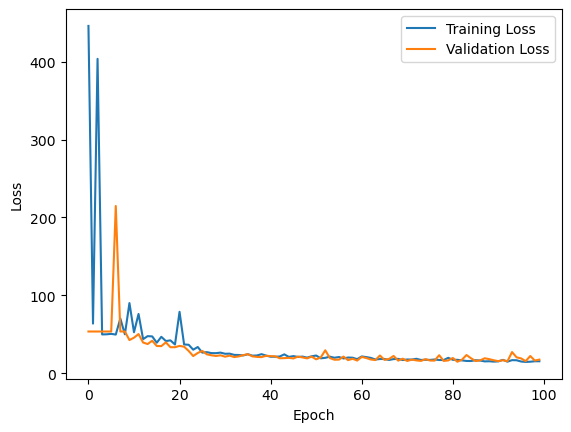

In [62]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb


# Initialize W&B
wandb.init(
    project="model1_spikes",  
    config={
        "learning_rate": 1e-3,
        "architecture": "SNN",
        "dataset": "Meerkat calls",
        "epochs": 100,
        "target_firing_rate_value": 10
    }
)

config = wandb.config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

# Hyperparameters
n_epochs = config.epochs
learning_rate = config.learning_rate
target_firing_rate_value = config.target_firing_rate_value 

optimizer = Adam(model1.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Store membrane potentials, spikes, syn currents
membrane_potentials = []
spike_outputs = []
synaptic_currents = []

# Store predictions and ground truth
predictions = []
ground_truths = []

# Training phase
for epoch in trange(n_epochs):
    model1.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1).to(device)

        # Inspect the inputs
        # print("Inputs shape:", inputs.shape)
        # print("Inputs mean:", inputs.mean().item())
        # print("Inputs max:", inputs.max().item())
        # print("Inputs min:", inputs.min().item())

        optimizer.zero_grad()
        outputs, _, _ = model1(inputs)
        outputs_sum = outputs.sum(dim=1)  # Sum over the time dimension

        # target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(device)
        target_firing_rate[labels == 1] = target_firing_rate_value
        target_firing_rate[labels == 0] = 0

        # Compute loss
        loss = loss_fun(outputs_sum, target_firing_rate)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if epoch == n_epochs - 1:
            predictions.append(outputs_sum.detach().cpu().numpy())  # Final output (spike prediction)
            ground_truths.append(labels.cpu().numpy()) 
        
        # Access internal layer membrane potentials and spikes
        for lyr_name in model1.lif_names:
            lyr = model1.seq[lyr_name]

            # Inspect membrane potentials and spikes
            # print(f"Layer {lyr_name}: Membrane potentials mean:", lyr.vmem.mean().item())
            # print(f"Layer {lyr_name}: Spikes sum:", lyr.spikes.sum().item())  # Sum of spikes should be > 0 if neurons are firing
            
            v_mem = lyr.vmem.detach().cpu().numpy()  # Membrane potentials
            spikes = lyr.spikes.detach().cpu().numpy()  # Spikes
            i_syn = lyr.isyn.detach().cpu().numpy()  # Synaptic currents
            
            # Store for visualization
            membrane_potentials.append(v_mem)
            spike_outputs.append(spikes)
            synaptic_currents.append(i_syn)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    model1.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            outputs, _, _ = model1(inputs)
            outputs_sum = outputs.sum(dim=1)
            target_firing_rate = torch.zeros_like(outputs_sum).to(device)
            target_firing_rate[labels == 1] = target_firing_rate_value
            target_firing_rate[labels == 0] = 0
            loss = loss_fun(outputs_sum, target_firing_rate)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
       
    # Log metrics to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1]
    })

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

wandb.finish()

predictions = np.concatenate(predictions)
ground_truths = np.concatenate(ground_truths)

# Save results
model1_outputs = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'membrane_potentials': membrane_potentials,
    'spike_outputs': spike_outputs,
    'synaptic_currents': synaptic_currents,
    'predictions': predictions,  
    'ground_truths': ground_truths
}

with open('model1_spikes.pkl', 'wb') as f:
    pickle.dump(model1_outputs, f)
    
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 - Vmem output

In [87]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  
n_classes = 1   
n_time = 101
dt = 10e-3     

model2 = SynNet(
    output="vmem",
    n_channels=n_channels,                        
    n_classes=n_classes,
    dt=dt,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[4, 8, 10],
    tau_syn_base=0.02,  
    tau_mem=0.02,
    tau_syn_out=0.02
)

print(model2)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [85]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "data_loader_to_model_training.ipynb"

  1%|          | 1/100 [00:45<1:15:30, 45.76s/it]

Epoch 1/100, Training Loss: 1.1208778844689422, Validation Loss: 1.3524824380874634


  2%|▏         | 2/100 [01:25<1:08:55, 42.20s/it]

Epoch 2/100, Training Loss: 1.2151902497939344, Validation Loss: 0.9508904559271676


  3%|▎         | 3/100 [01:59<1:02:04, 38.39s/it]

Epoch 3/100, Training Loss: 0.9980401970305532, Validation Loss: 0.8615861279623849


  4%|▍         | 4/100 [02:33<59:02, 36.91s/it]  

Epoch 4/100, Training Loss: 0.8634753497141712, Validation Loss: 0.7465473668915885


  5%|▌         | 5/100 [03:09<57:33, 36.36s/it]

Epoch 5/100, Training Loss: 0.7893909879450528, Validation Loss: 0.8407786978142602


  6%|▌         | 6/100 [03:45<56:39, 36.17s/it]

Epoch 6/100, Training Loss: 0.7209479522030309, Validation Loss: 0.6782358012029103


  7%|▋         | 7/100 [04:16<53:48, 34.71s/it]

Epoch 7/100, Training Loss: 0.6792032746773846, Validation Loss: 0.6875102732862745


  8%|▊         | 8/100 [04:48<51:38, 33.68s/it]

Epoch 8/100, Training Loss: 0.6584045437147032, Validation Loss: 0.6353981665202549


  9%|▉         | 9/100 [05:19<50:05, 33.03s/it]

Epoch 9/100, Training Loss: 0.649383786151994, Validation Loss: 0.6853421628475189


 10%|█         | 10/100 [05:56<51:14, 34.16s/it]

Epoch 10/100, Training Loss: 0.7657227656751309, Validation Loss: 0.7223258816770145


 11%|█         | 11/100 [06:35<52:42, 35.53s/it]

Epoch 11/100, Training Loss: 0.8056758675935134, Validation Loss: 0.6971410470349448


 12%|█▏        | 12/100 [07:09<51:45, 35.29s/it]

Epoch 12/100, Training Loss: 0.647716242749736, Validation Loss: 0.6276909517390388


 13%|█▎        | 13/100 [07:43<50:34, 34.88s/it]

Epoch 13/100, Training Loss: 0.6258881530671749, Validation Loss: 0.6317428648471832


 14%|█▍        | 14/100 [08:13<47:36, 33.22s/it]

Epoch 14/100, Training Loss: 0.6083590157751767, Validation Loss: 0.5630691477230617


 15%|█▌        | 15/100 [08:42<45:10, 31.89s/it]

Epoch 15/100, Training Loss: 0.5691542063119277, Validation Loss: 0.6331705152988434


 16%|█▌        | 16/100 [09:12<44:12, 31.57s/it]

Epoch 16/100, Training Loss: 0.549385204630078, Validation Loss: 0.5749048803533826


 17%|█▋        | 17/100 [09:45<44:03, 31.85s/it]

Epoch 17/100, Training Loss: 0.5581859097165881, Validation Loss: 0.5313678128378732


 18%|█▊        | 18/100 [10:12<41:44, 30.55s/it]

Epoch 18/100, Training Loss: 0.6172330998024851, Validation Loss: 0.6444456598588398


 19%|█▉        | 19/100 [10:37<38:37, 28.61s/it]

Epoch 19/100, Training Loss: 0.6316610141745154, Validation Loss: 0.6342038554804665


 20%|██        | 20/100 [11:01<36:28, 27.36s/it]

Epoch 20/100, Training Loss: 0.5781085075072523, Validation Loss: 0.5910536221095494


 21%|██        | 21/100 [11:26<34:55, 26.52s/it]

Epoch 21/100, Training Loss: 0.5922040056507543, Validation Loss: 0.5908461936882564


 22%|██▏       | 22/100 [11:49<33:17, 25.61s/it]

Epoch 22/100, Training Loss: 0.5235167381898412, Validation Loss: 0.5066512610231128


 23%|██▎       | 23/100 [12:13<32:22, 25.22s/it]

Epoch 23/100, Training Loss: 0.4958048091744477, Validation Loss: 0.561066461460931


 24%|██▍       | 24/100 [12:36<31:03, 24.53s/it]

Epoch 24/100, Training Loss: 0.5240735200778494, Validation Loss: 0.5559770677770887


 25%|██▌       | 25/100 [13:00<30:17, 24.24s/it]

Epoch 25/100, Training Loss: 0.5053268393396206, Validation Loss: 0.6255552811282021


 26%|██▌       | 26/100 [13:24<30:01, 24.35s/it]

Epoch 26/100, Training Loss: 0.5501947518227235, Validation Loss: 0.5937582680157253


 27%|██▋       | 27/100 [13:48<29:28, 24.23s/it]

Epoch 27/100, Training Loss: 0.5030234540408512, Validation Loss: 0.5098418465682438


 28%|██▊       | 28/100 [14:13<29:11, 24.32s/it]

Epoch 28/100, Training Loss: 0.46895731113991646, Validation Loss: 0.6846001126936504


 29%|██▉       | 29/100 [14:37<28:47, 24.34s/it]

Epoch 29/100, Training Loss: 0.4598257918402834, Validation Loss: 0.5036463269165584


 30%|███       | 30/100 [15:02<28:22, 24.32s/it]

Epoch 30/100, Training Loss: 0.45475067395084307, Validation Loss: 0.50393089226314


 31%|███       | 31/100 [15:26<27:54, 24.27s/it]

Epoch 31/100, Training Loss: 0.4649852896636387, Validation Loss: 0.5210098070757729


 32%|███▏      | 32/100 [15:49<27:14, 24.03s/it]

Epoch 32/100, Training Loss: 0.44642868244423056, Validation Loss: 0.4905978058065687


 33%|███▎      | 33/100 [16:14<27:10, 24.33s/it]

Epoch 33/100, Training Loss: 0.4857219935588117, Validation Loss: 0.5102072656154633


 34%|███▍      | 34/100 [16:39<27:01, 24.56s/it]

Epoch 34/100, Training Loss: 0.5196136213698477, Validation Loss: 0.48795859941414427


 35%|███▌      | 35/100 [17:03<26:26, 24.41s/it]

Epoch 35/100, Training Loss: 0.4393623651198621, Validation Loss: 0.5256308998380389


 36%|███▌      | 36/100 [17:27<25:46, 24.17s/it]

Epoch 36/100, Training Loss: 0.4564475270937074, Validation Loss: 0.5146974282605308


 37%|███▋      | 37/100 [17:50<25:09, 23.96s/it]

Epoch 37/100, Training Loss: 0.5330025086987693, Validation Loss: 0.5198542603424617


 38%|███▊      | 38/100 [18:13<24:20, 23.55s/it]

Epoch 38/100, Training Loss: 0.48836235617691615, Validation Loss: 0.5130973500864846


 39%|███▉      | 39/100 [18:37<24:12, 23.81s/it]

Epoch 39/100, Training Loss: 0.4278248627230806, Validation Loss: 0.5353896234716687


 40%|████      | 40/100 [19:01<23:48, 23.81s/it]

Epoch 40/100, Training Loss: 0.4360233387857113, Validation Loss: 0.5210971044642585


 41%|████      | 41/100 [19:26<23:48, 24.21s/it]

Epoch 41/100, Training Loss: 0.41252313216902176, Validation Loss: 0.558040269783565


 42%|████▏     | 42/100 [19:51<23:32, 24.36s/it]

Epoch 42/100, Training Loss: 0.5117104396505175, Validation Loss: 0.5696062530790057


 43%|████▎     | 43/100 [20:15<23:06, 24.33s/it]

Epoch 43/100, Training Loss: 0.40989614404597374, Validation Loss: 0.48183333022253855


 44%|████▍     | 44/100 [20:39<22:29, 24.10s/it]

Epoch 44/100, Training Loss: 0.37674422154449067, Validation Loss: 0.5745566529887063


 45%|████▌     | 45/100 [21:03<22:03, 24.05s/it]

Epoch 45/100, Training Loss: 0.38487751866286657, Validation Loss: 0.47390866705349516


 46%|████▌     | 46/100 [21:27<21:33, 23.96s/it]

Epoch 46/100, Training Loss: 0.3928313308729316, Validation Loss: 0.49470283516815733


 47%|████▋     | 47/100 [21:51<21:08, 23.93s/it]

Epoch 47/100, Training Loss: 0.4080530790225515, Validation Loss: 0.48855899061475483


 48%|████▊     | 48/100 [22:15<20:49, 24.02s/it]

Epoch 48/100, Training Loss: 0.3933631219672707, Validation Loss: 0.4963644721678325


 49%|████▉     | 49/100 [22:39<20:26, 24.04s/it]

Epoch 49/100, Training Loss: 0.4289663374986289, Validation Loss: 0.7248235110725675


 50%|█████     | 50/100 [23:03<19:56, 23.94s/it]

Epoch 50/100, Training Loss: 0.6043513394751638, Validation Loss: 0.6545566810028893


 51%|█████     | 51/100 [23:25<19:14, 23.55s/it]

Epoch 51/100, Training Loss: 0.5179076526524886, Validation Loss: 0.732545439686094


 52%|█████▏    | 52/100 [23:48<18:39, 23.31s/it]

Epoch 52/100, Training Loss: 0.5206798953267763, Validation Loss: 0.5327527246304921


 53%|█████▎    | 53/100 [24:11<18:12, 23.24s/it]

Epoch 53/100, Training Loss: 0.5081875442333941, Validation Loss: 0.5282950827053615


 54%|█████▍    | 54/100 [24:35<17:57, 23.42s/it]

Epoch 54/100, Training Loss: 0.48546877784549064, Validation Loss: 0.5387833075863975


 55%|█████▌    | 55/100 [25:00<17:54, 23.88s/it]

Epoch 55/100, Training Loss: 0.47059525127680796, Validation Loss: 0.4596640190907887


 56%|█████▌    | 56/100 [25:22<17:10, 23.43s/it]

Epoch 56/100, Training Loss: 0.4731111042904404, Validation Loss: 0.45009860396385193


 57%|█████▋    | 57/100 [25:45<16:44, 23.35s/it]

Epoch 57/100, Training Loss: 0.40284752058533, Validation Loss: 0.4720481293542044


 58%|█████▊    | 58/100 [26:07<16:00, 22.88s/it]

Epoch 58/100, Training Loss: 0.4131754101166185, Validation Loss: 0.4606912987572806


 59%|█████▉    | 59/100 [26:29<15:29, 22.67s/it]

Epoch 59/100, Training Loss: 0.36531066613377267, Validation Loss: 0.4584594688245228


 60%|██████    | 60/100 [26:52<15:04, 22.61s/it]

Epoch 60/100, Training Loss: 0.37285500568039015, Validation Loss: 0.505004284637315


 61%|██████    | 61/100 [27:15<14:48, 22.77s/it]

Epoch 61/100, Training Loss: 0.4034293904057089, Validation Loss: 0.5236851807151522


 62%|██████▏   | 62/100 [27:38<14:30, 22.91s/it]

Epoch 62/100, Training Loss: 0.4151721807583323, Validation Loss: 0.5310501647847039


 63%|██████▎   | 63/100 [28:01<14:02, 22.77s/it]

Epoch 63/100, Training Loss: 0.374267244816951, Validation Loss: 0.4471768332379205


 64%|██████▍   | 64/100 [28:23<13:31, 22.54s/it]

Epoch 64/100, Training Loss: 0.3623087886931761, Validation Loss: 0.42164723787988934


 65%|██████▌   | 65/100 [28:45<13:07, 22.51s/it]

Epoch 65/100, Training Loss: 0.378671278087598, Validation Loss: 0.3911927895886557


 66%|██████▌   | 66/100 [29:07<12:40, 22.35s/it]

Epoch 66/100, Training Loss: 0.36575631544275106, Validation Loss: 0.4849634915590286


 67%|██████▋   | 67/100 [29:30<12:21, 22.46s/it]

Epoch 67/100, Training Loss: 0.3551899722584014, Validation Loss: 0.42653352873665945


 68%|██████▊   | 68/100 [29:52<11:57, 22.42s/it]

Epoch 68/100, Training Loss: 0.36701736613264624, Validation Loss: 0.45617902278900146


 69%|██████▉   | 69/100 [30:14<11:35, 22.42s/it]

Epoch 69/100, Training Loss: 0.41888146102428436, Validation Loss: 0.4277863566364561


 70%|███████   | 70/100 [30:37<11:11, 22.38s/it]

Epoch 70/100, Training Loss: 0.3388134555996589, Validation Loss: 0.44223685349736896


 71%|███████   | 71/100 [30:58<10:39, 22.04s/it]

Epoch 71/100, Training Loss: 0.3341622694202189, Validation Loss: 0.3997160004717963


 72%|███████▏  | 72/100 [31:21<10:23, 22.27s/it]

Epoch 72/100, Training Loss: 0.35224008124391987, Validation Loss: 0.4301984863621848


 73%|███████▎  | 73/100 [31:44<10:08, 22.54s/it]

Epoch 73/100, Training Loss: 0.3570236510263299, Validation Loss: 0.4245919372354235


 74%|███████▍  | 74/100 [32:07<09:49, 22.66s/it]

Epoch 74/100, Training Loss: 0.34352367722763205, Validation Loss: 0.5056929162570408


 75%|███████▌  | 75/100 [32:29<09:25, 22.60s/it]

Epoch 75/100, Training Loss: 0.3556412750819944, Validation Loss: 0.46337643691471647


 76%|███████▌  | 76/100 [32:51<08:55, 22.30s/it]

Epoch 76/100, Training Loss: 0.3709691746054955, Validation Loss: 0.48145066520997454


 77%|███████▋  | 77/100 [33:13<08:29, 22.17s/it]

Epoch 77/100, Training Loss: 0.3239212754481244, Validation Loss: 0.41501274917806896


 78%|███████▊  | 78/100 [33:34<08:02, 21.95s/it]

Epoch 78/100, Training Loss: 0.31762583982550874, Validation Loss: 0.4498780774218695


 79%|███████▉  | 79/100 [33:56<07:40, 21.93s/it]

Epoch 79/100, Training Loss: 0.30843487831781496, Validation Loss: 0.4497634491750172


 80%|████████  | 80/100 [34:19<07:21, 22.07s/it]

Epoch 80/100, Training Loss: 0.35375465565132647, Validation Loss: 0.40117666125297546


 81%|████████  | 81/100 [34:41<07:03, 22.31s/it]

Epoch 81/100, Training Loss: 0.31454962864518166, Validation Loss: 0.37642507893698557


 82%|████████▏ | 82/100 [35:03<06:40, 22.23s/it]

Epoch 82/100, Training Loss: 0.31303621997248454, Validation Loss: 0.4687908504690443


 83%|████████▎ | 83/100 [35:27<06:21, 22.47s/it]

Epoch 83/100, Training Loss: 0.3341081717385436, Validation Loss: 0.4301993485007967


 84%|████████▍ | 84/100 [35:48<05:54, 22.13s/it]

Epoch 84/100, Training Loss: 0.3122768191234121, Validation Loss: 0.3874449346746717


 85%|████████▌ | 85/100 [36:10<05:30, 22.00s/it]

Epoch 85/100, Training Loss: 0.31519160714914213, Validation Loss: 0.45778721145221163


 86%|████████▌ | 86/100 [36:33<05:13, 22.41s/it]

Epoch 86/100, Training Loss: 0.3206851028327672, Validation Loss: 0.4426252416202


 87%|████████▋ | 87/100 [36:54<04:46, 22.00s/it]

Epoch 87/100, Training Loss: 0.3204833731617568, Validation Loss: 0.51227724977902


 88%|████████▊ | 88/100 [37:15<04:20, 21.71s/it]

Epoch 88/100, Training Loss: 0.3145634818751857, Validation Loss: 0.45463218646390097


 89%|████████▉ | 89/100 [37:39<04:04, 22.26s/it]

Epoch 89/100, Training Loss: 0.3021735525074995, Validation Loss: 0.46327814885548185


 90%|█████████ | 90/100 [38:02<03:45, 22.52s/it]

Epoch 90/100, Training Loss: 0.30743894501114793, Validation Loss: 0.4628810797418867


 91%|█████████ | 91/100 [38:25<03:24, 22.77s/it]

Epoch 91/100, Training Loss: 0.3046161559111667, Validation Loss: 0.5282526016235352


 92%|█████████▏| 92/100 [38:43<02:51, 21.40s/it]

Epoch 92/100, Training Loss: 0.3002954997684596, Validation Loss: 0.4119169754641397


 93%|█████████▎| 93/100 [39:01<02:21, 20.25s/it]

Epoch 93/100, Training Loss: 0.2945889745540214, Validation Loss: 0.4403412129197802


 94%|█████████▍| 94/100 [39:21<02:00, 20.16s/it]

Epoch 94/100, Training Loss: 0.34166442462295854, Validation Loss: 0.44467083896909443


 95%|█████████▌| 95/100 [39:43<01:44, 20.82s/it]

Epoch 95/100, Training Loss: 0.3092688054970975, Validation Loss: 0.3910312865461622


 96%|█████████▌| 96/100 [40:02<01:21, 20.34s/it]

Epoch 96/100, Training Loss: 0.3128182554863534, Validation Loss: 0.4796553467001234


 97%|█████████▋| 97/100 [40:23<01:01, 20.50s/it]

Epoch 97/100, Training Loss: 0.29628632569088126, Validation Loss: 0.4345031018768038


 98%|█████████▊| 98/100 [40:44<00:41, 20.60s/it]

Epoch 98/100, Training Loss: 0.3158428604310414, Validation Loss: 0.40683896626744953


 99%|█████████▉| 99/100 [41:04<00:20, 20.29s/it]

Epoch 99/100, Training Loss: 0.33850131619651364, Validation Loss: 0.3896751957280295


100%|██████████| 100/100 [41:24<00:00, 24.84s/it]

Epoch 100/100, Training Loss: 0.31106300160007655, Validation Loss: 0.40478735097817015


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▅▄▅▄▃▄▄▃▃▂▂▃▂▂▂▂▂▂▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▃▄▂▁▂▂▁▁▁▁▂▁▁▂▁▂▂▁▁▁▁
epoch,100
train_loss,0.31106
val_loss,0.40479


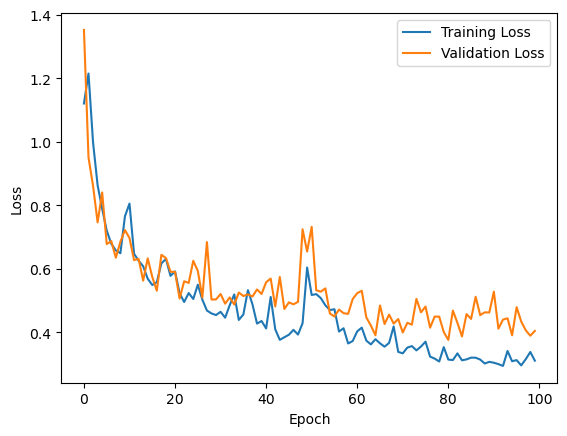

In [88]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle

wandb.init(
    project="model2_vmem",  
    config={
        "learning_rate": 1e-3,
        "architecture": "SNN",
        "dataset": "Meerkat calls",
        "epochs": 100,
        "target_class_potential": 1,
        "non_target_class_potential": -1
    }
)

config = wandb.config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

# Hyperparameters
n_epochs = config.epochs
learning_rate = config.learning_rate
target_class_potential = config.target_class_potential
non_target_class_potential = config.non_target_class_potential

optimizer = Adam(model2.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Store membrane potentials, spikes, syn currents
membrane_potentials = []
spike_outputs = []
synaptic_currents = []

# Store predictions and ground truth
predictions = []
ground_truths = []

# Training phase
for epoch in trange(n_epochs):
    model2.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1).to(device)

        # Inspect the inputs
        # print("Inputs shape:", inputs.shape)
        # print("Inputs mean:", inputs.mean().item())
        # print("Inputs max:", inputs.max().item())
        # print("Inputs min:", inputs.min().item())

        optimizer.zero_grad()
        outputs, _, _ = model2(inputs, record=True)
        outputs_vmem = outputs[:, -1, :]  # Last time step along the time axis

        # target membrane potential values
        target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
        target_membrane_potential[labels == 1] = target_class_potential  # Target class
        target_membrane_potential[labels == 0] = non_target_class_potential  # Non-target class

        # Compute loss
        loss = loss_fun(outputs_vmem, target_membrane_potential)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if epoch == n_epochs - 1:
            predictions.append(outputs_vmem.detach().cpu().numpy())  # Final output (membrane potential prediction)
            ground_truths.append(labels.cpu().numpy()) 
        
        # Access internal layer membrane potentials and spikes
        for lyr_name in model2.lif_names:
            lyr = model2.seq[lyr_name]

            # Inspect membrane potentials and spikes
            # print(f"Layer {lyr_name}: Membrane potentials mean:", lyr.vmem.mean().item())
            # print(f"Layer {lyr_name}: Spikes sum:", lyr.spikes.sum().item())  # Sum of spikes should be > 0 if neurons are firing
            
            v_mem = lyr.vmem.detach().cpu().numpy()  # Membrane potentials
            spikes = lyr.spikes.detach().cpu().numpy()  # Spikes
            i_syn = lyr.isyn.detach().cpu().numpy()  # Synaptic currents
            
            # Store for visualization
            membrane_potentials.append(v_mem)
            spike_outputs.append(spikes)
            synaptic_currents.append(i_syn)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            outputs, _, _ = model2(inputs, record=True)
            outputs_vmem = outputs[:, -1, :]
            target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
            target_membrane_potential[labels == 1] = target_class_potential
            target_membrane_potential[labels == 0] = non_target_class_potential
            loss = loss_fun(outputs_vmem, target_membrane_potential)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    wandb.log({
    "epoch": epoch + 1,
    "train_loss": train_losses[-1],
    "val_loss": val_losses[-1]
})

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

wandb.finish()

predictions = np.concatenate(predictions)
ground_truths = np.concatenate(ground_truths)

# Save results
model2_outputs = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'membrane_potentials': membrane_potentials,
    'spike_outputs': spike_outputs,
    'synaptic_currents': synaptic_currents,
    'predictions': predictions,  
    'ground_truths': ground_truths
}

with open('model2_vmem_4810.pkl', 'wb') as f:
    pickle.dump(model2_outputs, f)
    
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [105]:
import pickle
import numpy as np

with open('model2_vmem_4810.pkl', 'rb') as f:
    model2_outputs = pickle.load(f)

predictions = model2_outputs['predictions']  
ground_truths = model2_outputs['ground_truths']  

# Convert the predictions to binary labels (1 for target class, 0 for non-target class)
predicted_labels = np.where(predictions > 0, 1, 0)   
predicted_labels = predicted_labels.flatten()

# Flatten the ground truths array (from 2D to 1D)
ground_truths = np.array(ground_truths).flatten()

# Debugging
print(f"Shape of predicted_labels: {predicted_labels.shape}")
print(f"Shape of ground_truths: {ground_truths.shape}")

correct_predictions = (predicted_labels == ground_truths).sum()
total_predictions = ground_truths.shape[0]

accuracy = (correct_predictions / total_predictions) * 100
print(f"Model accuracy: {accuracy:.2f}%")

Shape of predicted_labels: (1672,)
Shape of ground_truths: (1672,)
Model accuracy: 91.75%
